# Data Import and Preprocessing

In [133]:
# All imports, setup logging and get configuration file

from utils import get_configuration_file, setup_logging, impute_null_values
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns

setup_logging()
config = get_configuration_file()

In [2]:
# Importing data

holiday_events = pd.read_csv(config["holiday_events_data_location"])
oil = pd.read_csv(config["oil_data_location"])
sample_submission = pd.read_csv(config["sample_submission_data_location"])
stores = pd.read_csv(config["stores_data_location"])
test = pd.read_csv(config["test_data_location"])
train = pd.read_csv(config["train_data_location"])
transactions = pd.read_csv(config["transactions_data_location"])

In [3]:
# Impute null values in oil prices table

oil.rename(columns={"dcoilwtico":"oil_price"},inplace = True)

for index in range(len(oil)):
    if np.isnan(oil.loc[index, "oil_price"]):
        above_oil_price_index = oil["oil_price"][:index].last_valid_index()
        below_oil_price_index = oil["oil_price"][index:].first_valid_index()
        if above_oil_price_index is not None and below_oil_price_index is not None:
            above_oil_price_value = oil.loc[above_oil_price_index, "oil_price"]
            below_oil_price_value = oil.loc[below_oil_price_index, "oil_price"]
            oil.loc[index, "oil_price"] = (above_oil_price_value+below_oil_price_value)/2
        if above_oil_price_index is not None:
            oil.loc[index, "oil_price"] = oil["oil_price"].iloc[above_oil_price_index]
        if below_oil_price_index is not None:
            oil.loc[index, "oil_price"] = oil["oil_price"].iloc[below_oil_price_index]
        
        

In [4]:
# Add holiday column in holiday_events file and rename columns

stores.rename(columns={"type":"store_type"}, inplace = True)
holiday_events.rename(columns={"type":"holiday_type"}, inplace = True)
holiday_events["holiday"] = np.where((holiday_events["holiday_type"].
                                      isin(["Holiday","Transfer","Event",
                                           "Bridge","Additional"]) &
                                     (holiday_events["transferred"]==False)),1,0)
holiday_events_national = holiday_events[holiday_events["locale"]=="National"]

In [5]:
# Merging data

# Merging with Oil data
training_dataset = train.merge(stores, on = "store_nbr", how = "inner")
training_dataset = training_dataset.merge(oil, on = "date", how = "left")

# Merging with holiday events
training_dataset_temp = training_dataset.merge(holiday_events[["date","locale_name",
                                                               "holiday"]], how = "left",
                                                                right_on = 
                                                                ["date","locale_name"], 
                                                                left_on = ["date","city"])
training_dataset_temp.rename(columns={"holiday":"local_holiday"},inplace=True)
training_dataset_temp.drop(columns="locale_name",inplace=True)

training_dataset_temp = training_dataset_temp.merge(holiday_events_national
                                                    [["date","holiday"]],how = "left", 
                                                    left_on = "date", right_on = "date")
training_dataset_temp.rename(columns={"holiday":"national_holiday"},inplace=True)

training_dataset_temp.fillna({"local_holiday":0,"national_holiday":0},inplace = True)

training_dataset = training_dataset_temp

# training_dataset

In [6]:
# Change data types

training_dataset["date"] = pd.to_datetime(training_dataset["date"])

In [122]:
# Add features of day of week and month of year

training_dataset["dayOfWeek"] = training_dataset["date"].apply(lambda x: x.day_of_week)
training_dataset["monthOfYear"] = training_dataset["date"].apply(lambda x: x.month)

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,oil_price,local_holiday,national_holiday,dayOfWeek,monthOfYear
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,93.14,0.0,1.0,1,1
1194,1194,2013-01-01,42,CELEBRATION,0.000,0,Cuenca,Azuay,D,2,93.14,0.0,1.0,1,1
1193,1193,2013-01-01,42,BREAD/BAKERY,0.000,0,Cuenca,Azuay,D,2,93.14,0.0,1.0,1,1
1192,1192,2013-01-01,42,BOOKS,0.000,0,Cuenca,Azuay,D,2,93.14,0.0,1.0,1,1
1191,1191,2013-01-01,42,BEVERAGES,0.000,0,Cuenca,Azuay,D,2,93.14,0.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007085,2999693,2017-08-15,25,PET SUPPLIES,3.000,0,Salinas,Santa Elena,D,1,47.57,0.0,0.0,1,8
3007084,2999692,2017-08-15,25,PERSONAL CARE,93.000,8,Salinas,Santa Elena,D,1,47.57,0.0,0.0,1,8
3007083,2999691,2017-08-15,25,MEATS,180.107,0,Salinas,Santa Elena,D,1,47.57,0.0,0.0,1,8
3007094,2999702,2017-08-15,26,BEAUTY,0.000,0,Guayaquil,Guayas,D,10,47.57,0.0,0.0,1,8


In [112]:
# Impute Null values

training_dataset = impute_null_values(training_dataset, "oil_price")


In [125]:
# Save the training dataset

training_dataset.to_csv("training_dataset.csv",index=False)

In [126]:
training_dataset.isna().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
store_type          0
cluster             0
oil_price           0
local_holiday       0
national_holiday    0
dayOfWeek           0
monthOfYear         0
dtype: int64

In [127]:
training_dataset.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'oil_price', 'local_holiday',
       'national_holiday', 'dayOfWeek', 'monthOfYear'],
      dtype='object')

In [128]:
training_dataset.describe()

,id,date,store_nbr,sales,onpromotion,cluster,oil_price,local_holiday,national_holiday,dayOfWeek,monthOfYear
count,3.008280e+06,3008280,3.008280e+06,3.008280e+06,3.008280e+06,3.008280e+06,3.008280e+06,3.008280e+06,3.008280e+06,3.008280e+06,3.008280e+06
mean,1.501579e+06,2015-04-24 23:47:40.728390144,2.750037e+01,3.582643e+02,2.609735e+00,8.481395e+00,6.780945e+01,4.036858e-03,7.996928e-02,3.002633e+00,6.209193e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,7.520698e+05,2014-02-28 00:00:00,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.629000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00
50%,1.502358e+06,2015-04-26 00:00:00,2.800000e+01,1.100000e+01,0.000000e+00,8.500000e+00,5.319000e+01,0.000000e+00,0.000000e+00,3.000000e+00,6.000000e+00
75%,2.249081e+06,2016-06-19 00:00:00,4.100000e+01,1.960000e+02,0.000000e+00,1.300000e+01,9.580000e+01,0.000000e+00,0.000000e+00,5.000000e+00,9.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02,1.000000e+00,1.000000e+00,6.000000e+00,1.200000e+01
std,8.657256e+05,NaN,1.558533e+01,1.103486e+03,1.226302e+01,4.649769e+00,2.569562e+01,6.340791e-02,2.712457e-01,2.001885e+00,3.384834e+00


In [129]:
training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3008280 entries, 0 to 3008279
Data columns (total 15 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                int64         
 1   date              datetime64[ns]
 2   store_nbr         int64         
 3   family            object        
 4   sales             float64       
 5   onpromotion       int64         
 6   city              object        
 7   state             object        
 8   store_type        object        
 9   cluster           int64         
 10  oil_price         float64       
 11  local_holiday     float64       
 12  national_holiday  float64       
 13  dayOfWeek         int64         
 14  monthOfYear       int64         
dtypes: datetime64[ns](1), float64(4), int64(6), object(4)
memory usage: 431.7+ MB


# Data Visualization

/var/folders/t2/rv4p8zx13gj6mt8wcy_ckn3w0000gn/T/ipykernel_19148/1681338815.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(),rotation = 90)
/var/folders/t2/rv4p8zx13gj6mt8wcy_ckn3w0000gn/T/ipykernel_19148/1681338815.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(),rotation = 90)
/var/folders/t2/rv4p8zx13gj6mt8wcy_ckn3w0000gn/T/ipykernel_19148/1681338815.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(),rotation = 90)


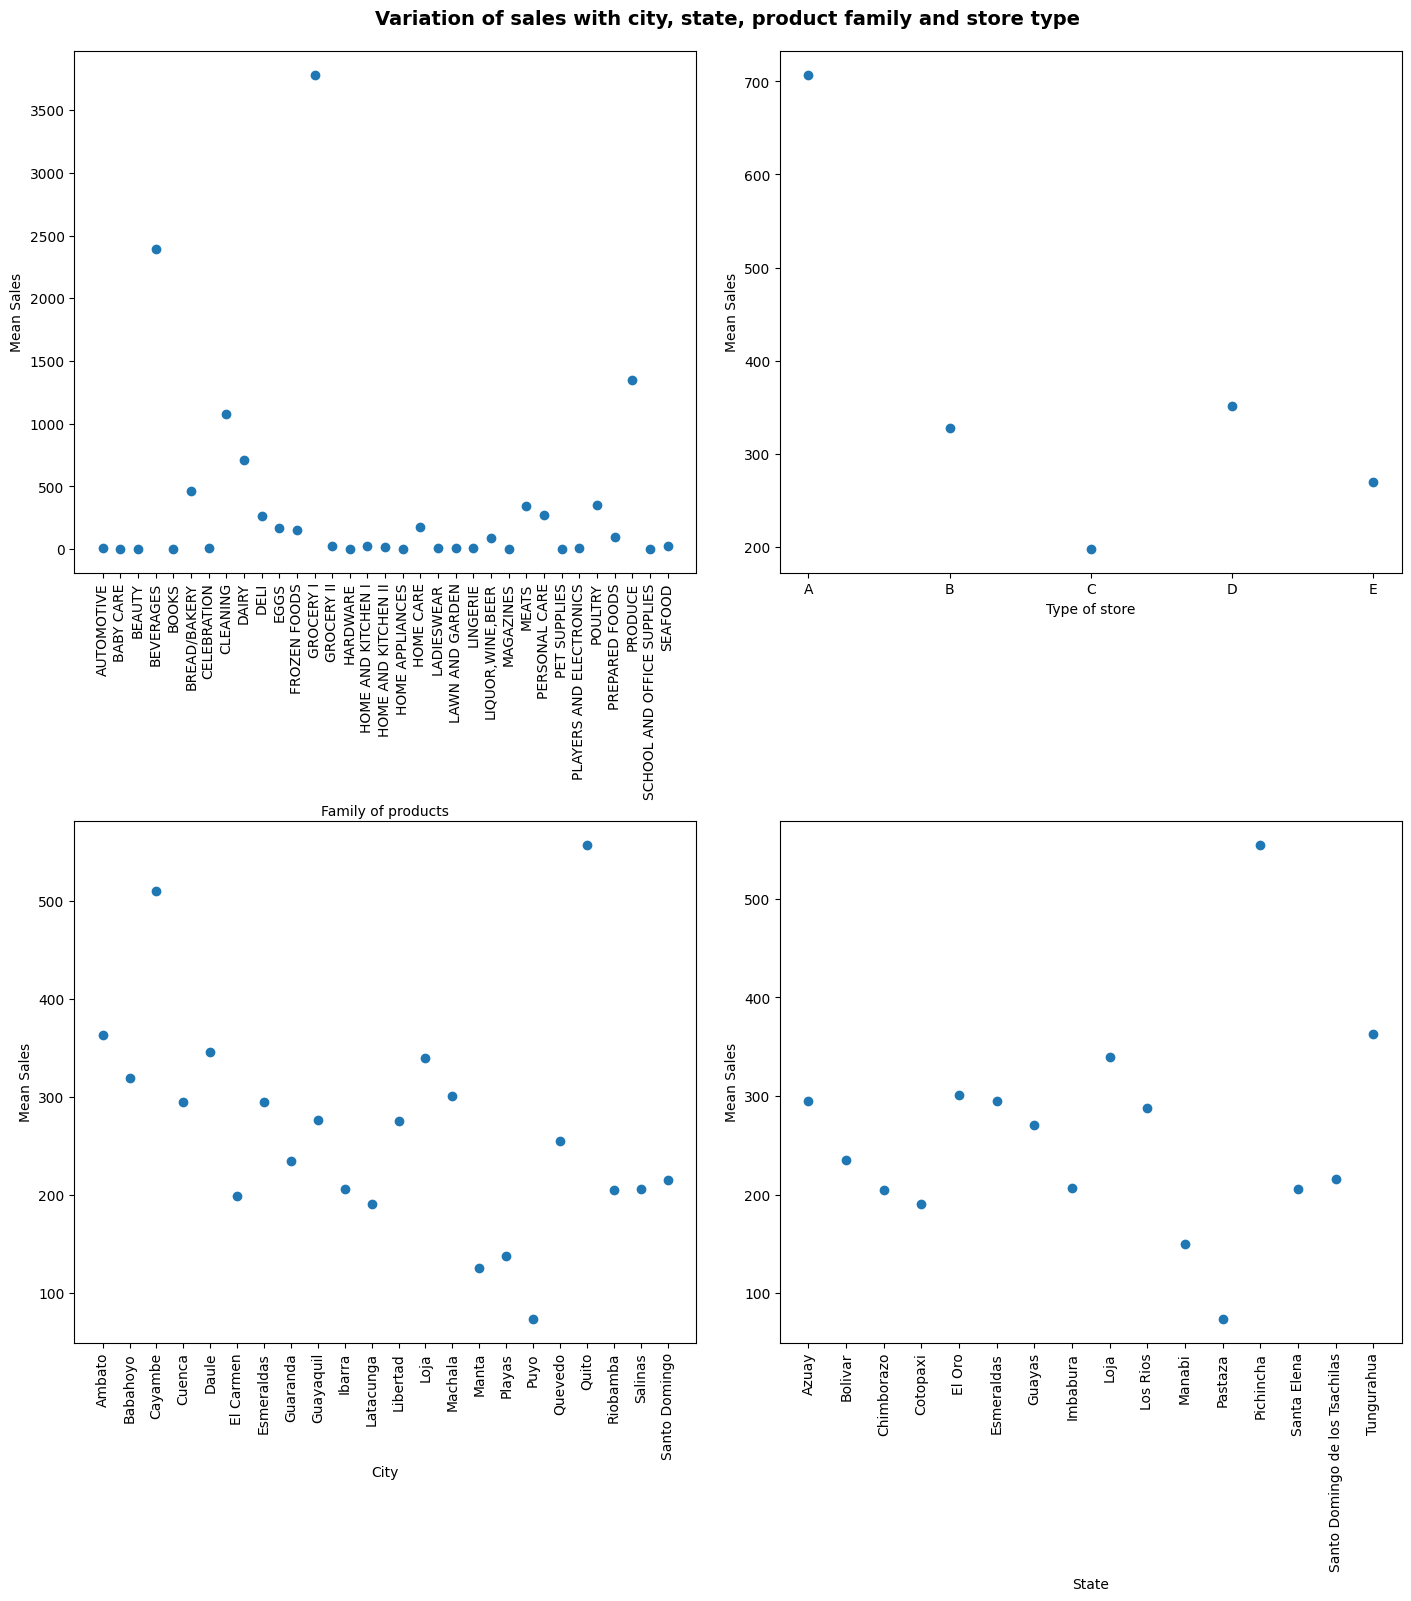

In [16]:
fig, ax = plt.subplots(2,2, figsize = (14,14))
fig.suptitle("Variation of sales with city, state, product family and store type", size = 14, 
             weight = "bold")

fig.tight_layout(h_pad = 16, w_pad = 3)

groupby_column = "family"
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
ax[0,0].scatter(x = grouped[groupby_column], y = grouped["sales"])
ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(),rotation = 90)
ax[0,0].set_xlabel("Family of products")
ax[0,0].set_ylabel("Mean Sales")

groupby_column = "store_type"
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
ax[0,1].scatter(x = grouped[groupby_column], y = grouped["sales"])
ax[0,1].set_xlabel("Type of store")
ax[0,1].set_ylabel("Mean Sales")

groupby_column = "city"
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
ax[1,0].scatter(x = grouped[groupby_column], y = grouped["sales"])
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(),rotation = 90)
ax[1,0].set_xlabel("City")
ax[1,0].set_ylabel("Mean Sales")

groupby_column = "state"
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
ax[1,1].scatter(x = grouped[groupby_column], y = grouped["sales"])
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(),rotation = 90)
ax[1,1].set_xlabel("State")
ax[1,1].set_ylabel("Mean Sales")

plt.subplots_adjust(top=0.95)

# plt.savefig('Visualizations/Sales scatter plots .png')

In [76]:
groupby_column = ["store_nbr","family"]
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
grouped

,store_nbr,family,sales
0,1,AUTOMOTIVE,3.249408
1,1,BABY CARE,0.000000
2,1,BEAUTY,2.408768
3,1,BEVERAGES,1587.809834
4,1,BOOKS,0.125000
...,...,...,...
1777,54,POULTRY,52.835036
1778,54,PREPARED FOODS,61.226303
1779,54,PRODUCE,354.878766
1780,54,SCHOOL AND OFFICE SUPPLIES,0.626185


# Data Preparation for modelling

In [241]:
# Import data
training_dataset = pd.read_csv("training_dataset.csv")
training_dataset["date"] = pd.to_datetime(training_dataset["date"])
training_dataset = training_dataset.sort_values(by = "date")
print("Number of columns in dataset: ", len(training_dataset.columns))
training_dataset.columns

Number of columns in dataset:  15


Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'oil_price', 'local_holiday',
       'national_holiday', 'dayOfWeek', 'monthOfYear'],
      dtype='object')

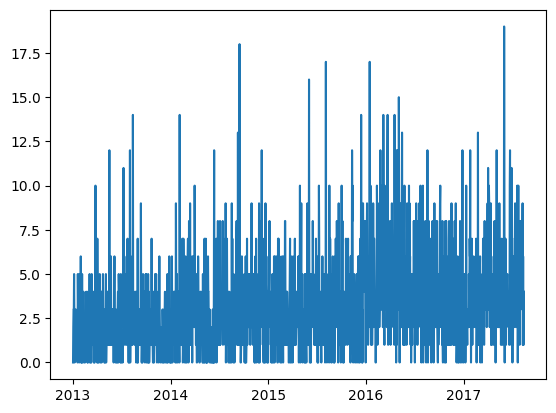

21


Index(['onpromotion', 'oil_price', 'local_holiday', 'national_holiday',
       'dayOfWeek_1', 'dayOfWeek_2', 'dayOfWeek_3', 'dayOfWeek_4',
       'dayOfWeek_5', 'dayOfWeek_6', 'monthOfYear_2', 'monthOfYear_3',
       'monthOfYear_4', 'monthOfYear_5', 'monthOfYear_6', 'monthOfYear_7',
       'monthOfYear_8', 'monthOfYear_9', 'monthOfYear_10', 'monthOfYear_11',
       'monthOfYear_12'],
      dtype='object')

In [242]:
# Check for one particular store and family of product

training_dataset = training_dataset[(training_dataset["store_nbr"]==1)&(training_dataset["family"]=="AUTOMOTIVE")]
X = training_dataset[["onpromotion","oil_price","local_holiday","national_holiday","dayOfWeek","monthOfYear"]]
y = training_dataset["sales"]

plt.plot(training_dataset["date"], training_dataset["sales"])
plt.show()

X = pd.get_dummies(X, columns = ["dayOfWeek","monthOfYear"], dtype = int)

X.drop(columns = ["dayOfWeek_0","monthOfYear_1"], inplace = True)

X_dropped_sparsity = X

print (len(X.columns))
X.columns


In [243]:
# Divide data into X and y

# X = training_dataset[config["training_columns"]]
# y = training_dataset["sales"]
# print("Number of columns in training dataset: ",len(X.columns))
# X.columns

In [244]:
# One hot categorical columns

# X = pd.get_dummies(X, columns = config["categorical_columns"], dtype = int)

# X.drop(columns = config["encoded_columns_drop"], inplace = True)
# len(X.columns)

In [184]:
# Calculate sparsity of feature matrix
non_zero_cells_count = np.count_nonzero(X)
total_cells_count = X.size
sparsity = (1-(non_zero_cells_count/total_cells_count))*100
sparsity

86.388512751072

In [173]:
# Drop columns based on sparsity in X
sparsity_column_threshold = config["sparsity_column_threshold"]

sparsity_column_wise = pd.DataFrame({"columnName":[],"sparsityPercent":[]})

for column in X.columns:
    non_zero_cells_count = np.count_nonzero(X[column])
    total_cells_count = X[column].size
    sparsity_column = (1-(non_zero_cells_count/total_cells_count))
    sparsity_column_wise = sparsity_column_wise._append({"columnName":column,"sparsityPercent":
                                                         sparsity_column}, ignore_index=True)

sparsity_column_wise.sort_values(by="sparsityPercent", ascending = False, inplace=True)
columns_to_drop = sparsity_column_wise[sparsity_column_wise["sparsityPercent"]>
                                       sparsity_column_threshold]["columnName"].tolist()

print("Columns dropped: ",columns_to_drop)
X_dropped_sparsity = X.drop(columns_to_drop, axis=1)
len(X_dropped_sparsity.columns)


Columns dropped:  ['local_holiday', 'onpromotion']


19

In [185]:
# Calculate statistics on X
correlation_matrix = X_dropped_sparsity.corr()
X_dropped_sparsity_stats = X_dropped_sparsity.describe()

In [186]:
# Checking variance in each column

X_dropped_sparsity_stats.loc["std",:].sort_values(ascending=False)

oil_price           25.703254
dayOfWeek_1          0.350548
dayOfWeek_5          0.350548
dayOfWeek_6          0.350548
dayOfWeek_4          0.349944
dayOfWeek_2          0.349338
dayOfWeek_3          0.349338
monthOfYear_5        0.291360
monthOfYear_3        0.288864
monthOfYear_7        0.288864
monthOfYear_4        0.284630
monthOfYear_6        0.284630
monthOfYear_2        0.276765
monthOfYear_8        0.274973
national_holiday     0.271337
monthOfYear_10       0.260967
monthOfYear_12       0.258038
monthOfYear_9        0.257051
monthOfYear_11       0.257051
onpromotion          0.090719
local_holiday        0.068700
Name: std, dtype: float64

[]

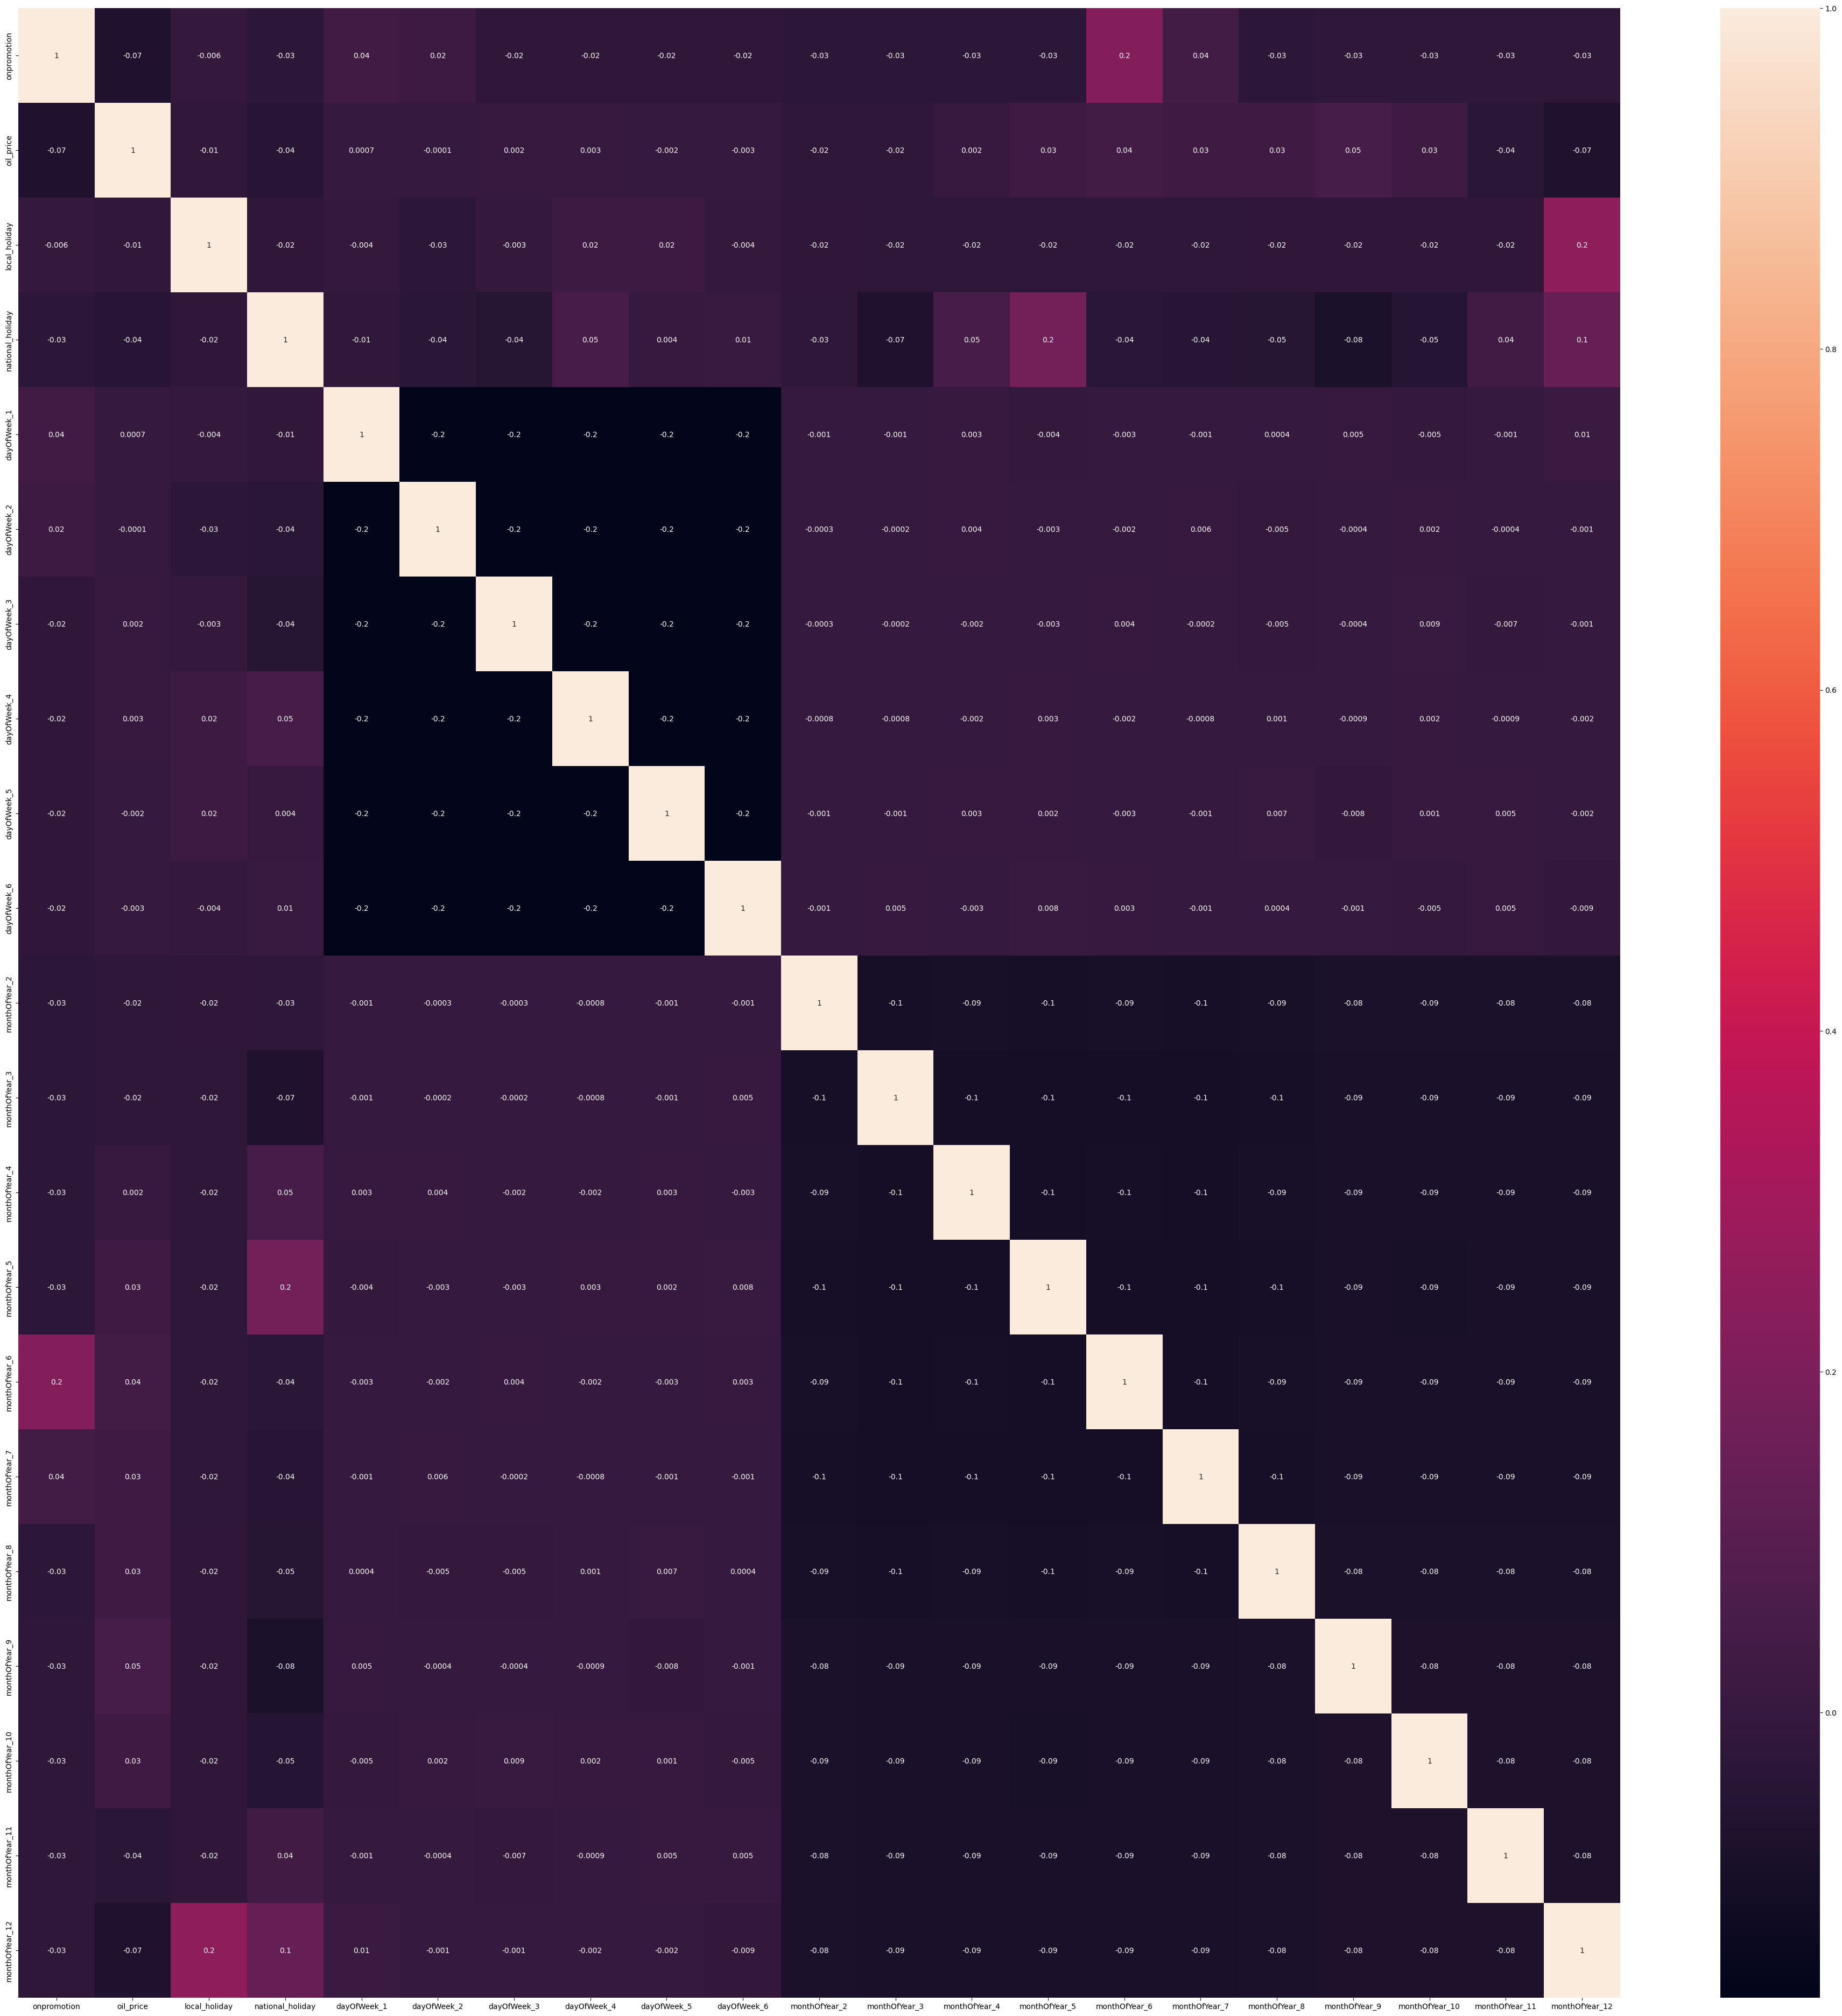

In [187]:
# Plot correlation heatmap
plt.figure(figsize=(48,48))
sns.heatmap(correlation_matrix, annot = True, fmt = '.1g')
plt.plot()

# plt.savefig('Visualizations/Correlation plot.png')

In [188]:
# Drop highly correlated features

correlation_matrix_absolute = correlation_matrix.abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix_absolute.where(np.triu(np.ones(correlation_matrix_absolute.shape),
                                                   k=1).astype(bool))

# Find features with correlation greater than threshold
threshold = config["correlation_threshold"]
columns_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print("The columns to be dropped are: ", columns_to_drop)

# Drop features 
X_dropped_sparsity_correlation = X_dropped_sparsity.drop(columns_to_drop, axis=1)

print(len(X_dropped_sparsity_correlation.columns))

The columns to be dropped are:  []
21


In [189]:
correlations_with_target = pd.DataFrame({"columnName":[],"correlation":[]})
for column in X_dropped_sparsity_correlation.columns:
    correlation = {"columnName":column,"correlation":X_dropped_sparsity_correlation[column].corr(y)}
    correlations_with_target = correlations_with_target._append(correlation, ignore_index=True)

correlations_with_target.sort_values(by="correlation", ascending=False)

,columnName,correlation
4,dayOfWeek_1,0.092348
7,dayOfWeek_4,0.082222
8,dayOfWeek_5,0.067214
0,onpromotion,0.048580
5,dayOfWeek_2,0.043763
15,monthOfYear_7,0.038195
12,monthOfYear_4,0.025360
11,monthOfYear_3,0.021828
16,monthOfYear_8,0.015109
14,monthOfYear_6,0.005730


In [190]:
# Calculate sparsity of feature matrix
non_zero_cells_count = np.count_nonzero(X)
total_cells_count = X_dropped_sparsity_correlation.size
sparsity = (1-(non_zero_cells_count/total_cells_count))*100
sparsity

86.388512751072

# Model training

In [191]:
X_dev, X_test, y_dev, y_test = train_test_split(X_dropped_sparsity_correlation, y, test_size = 0.2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.25)

In [192]:
print("X_train shape: ",X_train.shape)
print("X_val shape: ",X_val.shape)
print("X_test shape: ",X_test.shape)

X_train shape:  (1012, 21)
X_val shape:  (338, 21)
X_test shape:  (338, 21)


## Linear Regression

In [240]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
model_linear.score(X_train, y_train)

0.17425113050145546

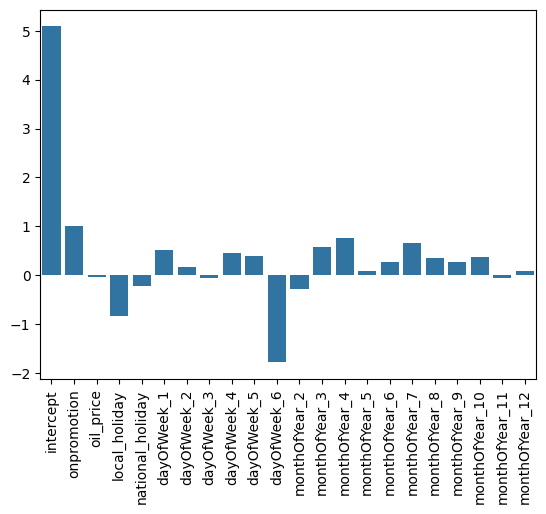

In [228]:
# Get feature importance for linear regression

feature_names = list(X_dropped_sparsity_correlation.columns)
feature_names.insert(0,'intercept')

coeffecients = list(model_linear.coef_)
coeffecients.insert(0,model_linear.intercept_)

sns.barplot(x=feature_names, y=coeffecients)
plt.xticks(rotation=90)
plt.show()

In [194]:
model_linear.score(X_val, y_val)

0.10465997352494572

## Random Forest

In [235]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
model_rf.score(X_train, y_train)

0.8528905656548392

In [237]:
model_rf.score(X_val, y_val)

0.008601987867520422

## Gradient Boosting

In [238]:
model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)
model_gb.score(X_train, y_train)

0.38746931936620177

In [239]:
model_gb.score(X_val, y_val)

0.09643714652522406

**Looking at the problem from business point of view, sales of products in a shop should depend on following factors:**

item, city, state, location, marketing, discount, festival, price change, substitute item price,
online penetration for delivery, delivery region, competitors (shops, online) in the region, offers to customers like debt,
home delivery etc., nature of shopkeeper, salesmanship of shopkeeper, wealth of people in the region where shop is located, 


In [32]:
training_dataset

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,oil_price,local_holiday,national_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,93.14,0.0,1.0
1194,1194,2013-01-01,42,CELEBRATION,0.000,0,Cuenca,Azuay,D,2,93.14,0.0,1.0
1193,1193,2013-01-01,42,BREAD/BAKERY,0.000,0,Cuenca,Azuay,D,2,93.14,0.0,1.0
1192,1192,2013-01-01,42,BOOKS,0.000,0,Cuenca,Azuay,D,2,93.14,0.0,1.0
1191,1191,2013-01-01,42,BEVERAGES,0.000,0,Cuenca,Azuay,D,2,93.14,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007085,2999693,2017-08-15,25,PET SUPPLIES,3.000,0,Salinas,Santa Elena,D,1,47.57,0.0,0.0
3007084,2999692,2017-08-15,25,PERSONAL CARE,93.000,8,Salinas,Santa Elena,D,1,47.57,0.0,0.0
3007083,2999691,2017-08-15,25,MEATS,180.107,0,Salinas,Santa Elena,D,1,47.57,0.0,0.0
3007094,2999702,2017-08-15,26,BEAUTY,0.000,0,Guayaquil,Guayas,D,10,47.57,0.0,0.0


In [44]:
training_dataset.groupby(["store_type","cluster"]).size().to_frame().reset_index()
# training_dataset["cluster"].value_counts().shape

,store_type,cluster,0
0,A,5,55704
1,A,11,167112
2,A,14,222816
3,A,17,55737
4,B,6,334257
5,B,10,55704
6,B,16,55704
7,C,3,389994
8,C,7,111408
9,C,12,55704


In [101]:
grouped = training_dataset.groupby(["store_type","family"]).agg({"sales":"mean"}).reset_index()
grouped = grouped[grouped["sales"]>0]
grouped

,store_type,family,sales
0,A,AUTOMOTIVE,12.142895
2,A,BEAUTY,8.595472
3,A,BEVERAGES,4746.301784
4,A,BOOKS,0.194037
5,A,BREAD/BAKERY,849.062446
...,...,...,...
160,E,POULTRY,154.269992
161,E,PREPARED FOODS,52.401830
162,E,PRODUCE,727.762456
163,E,SCHOOL AND OFFICE SUPPLIES,3.182262


In [107]:
a = grouped[grouped["store_type"]=="E"]
print (a.shape)
print ("Total unique product families: ", training_dataset["family"].value_counts().shape)
a

(32, 3)
Total unique product families:  (33,)


,store_type,family,sales
132,E,AUTOMOTIVE,5.026355
133,E,BABY CARE,0.083654
134,E,BEAUTY,1.516731
135,E,BEVERAGES,2124.762955
137,E,BREAD/BAKERY,407.659313
138,E,CELEBRATION,5.664791
139,E,CLEANING,836.130293
140,E,DAIRY,461.956766
141,E,DELI,228.447568
142,E,EGGS,146.225496


In [63]:
stores["type"].value_counts()

type
D    18
C    15
A     9
B     8
E     4
Name: count, dtype: int64

In [64]:
stores["store_nbr"]

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
25    26
26    27
27    28
28    29
29    30
30    31
31    32
32    33
33    34
34    35
35    36
36    37
37    38
38    39
39    40
40    41
41    42
42    43
43    44
44    45
45    46
46    47
47    48
48    49
49    50
50    51
51    52
52    53
53    54
Name: store_nbr, dtype: int64

In [65]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


Obsevations about dataset:

Number of stores - 54 (Unique store_nbr)
Number of cities - 22
Number of states - 16
Number of clusters - 17
Number of store types - 5 (Unique store_type)

Number of unique family of products - 33
Date range of sales at stores - 1/1/2013 to 15/8/2017





In [69]:
stores["cluster"].value_counts().shape

(17,)

In [70]:
training_dataset[["store_nbr","family","sales"]]

,store_nbr,family,sales
0,1,AUTOMOTIVE,0.000
1194,42,CELEBRATION,0.000
1193,42,BREAD/BAKERY,0.000
1192,42,BOOKS,0.000
1191,42,BEVERAGES,0.000
...,...,...,...
3007085,25,PET SUPPLIES,3.000
3007084,25,PERSONAL CARE,93.000
3007083,25,MEATS,180.107
3007094,26,BEAUTY,0.000


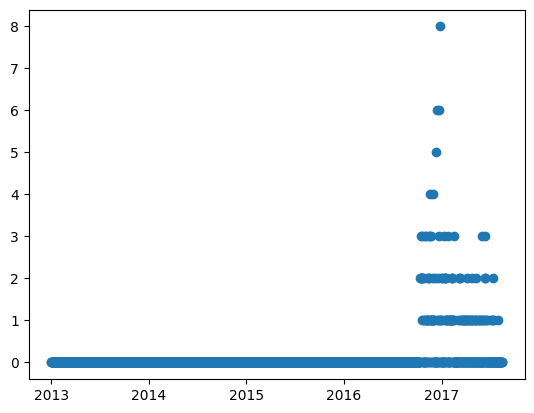

In [94]:
a = training_dataset[(training_dataset["store_nbr"]==1)&(training_dataset["family"]=="BOOKS")][["date","sales"]]
plt.scatter(x = a["date"], y=a["sales"])